# Real Bogus Experiment

We used three subtraction techniques

Zackay's and Bramich's DIA algorithms, plus HOTPANTS source code.
All of them were applied on the same new--ref pair of images and the same source identification algorithm.
Each dataset is comparable... 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_context(font_scale=1.2)

In [3]:
from sqlalchemy import create_engine
import pandas as pd

In [4]:
import os
plot_dir = os.path.abspath('./plots_three/.')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

In [5]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

Asking to the database for the undetected objects (False Negatives)

In [6]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [7]:
und_z = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN Undetected U
                             ON S.id==U.simulated_id""", 
                          engine)

In [8]:
und_b = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedOIS U
                             ON S.id==U.simulated_id""", 
                          engine)

In [9]:
und_h = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedHOT U
                             ON S.id==U.simulated_id""", 
                          engine)

Querying the database to obtain the tables related to the detections.

In [10]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [11]:
# dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
# dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)

### Some plots of simulated objects

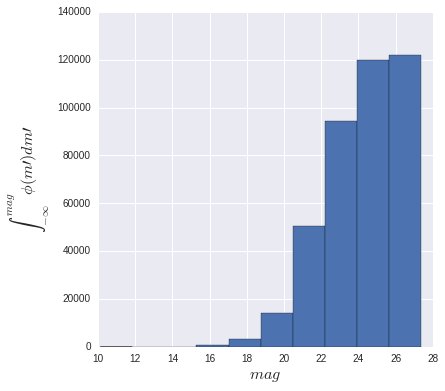

In [12]:
plt.figure(figsize=(6,6))
plt.hist(simulated['app_mag'], cumulative=True)
plt.xlabel(r'$mag$', fontsize=16)
plt.ylabel(r'$\int_{-\infty}^{mag}\phi(m\prime)dm\prime$', fontsize=16)
plt.savefig(os.path.join(plot_dir, 'lum_fun_simulated.png'), dpi=700)

### Analyzing the fraction of type of objects for each dataset

In [13]:
ois = [sum(dt_ois.IS_REAL), len(und_b), len(dt_ois.IS_REAL)-sum(dt_ois.IS_REAL)]
zps = [sum(dt_zps.IS_REAL), len(und_z), len(dt_zps.IS_REAL)-sum(dt_zps.IS_REAL)]
hot = [sum(dt_hot.IS_REAL), len(und_h), len(dt_hot.IS_REAL)-sum(dt_hot.IS_REAL)]
df2 = pd.DataFrame([zps, ois, hot], columns=['Real', 'False Neg', 'Bogus'])

In [14]:
df2['TP'] = df2['Real']/(df2['Real']+df2['False Neg'])
df2['FN'] = df2['False Neg']/(df2['Real']+df2['False Neg'])
df2['FP'] = df2['Bogus']/(df2['Real']+df2['False Neg'])

In [15]:
df2

,Real,False Neg,Bogus,TP,FN,FP
0,45445,76457,15393,0.372799,0.627201,0.126274
1,56239,65663,76722,0.461346,0.538654,0.629374
2,48968,72934,243953,0.401700,0.598300,2.001222


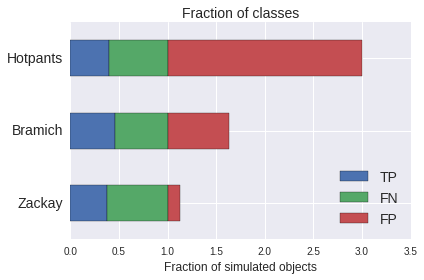

In [16]:
plt.figure(figsize=(12, 2))
df2[['TP', 'FN', 'FP']].plot.barh(stacked=True)
plt.title('Fraction of classes', fontsize=14)
plt.xscale('linear')
plt.xlabel('Fraction of simulated objects', fontsize=12)
plt.xlim(0, 3.5)
plt.yticks([0,1,2], ['Zackay', 'Bramich', 'Hotpants'], fontsize=14)

plt.vlines(df2[1:2]['Real'], -0.4, 2.3, lw=0.3)
plt.vlines(df2[1:2]['Real']+df2[1:2]['False Neg'], -0.4, 2.3, lw=0.6)

plt.tight_layout()
plt.legend(loc='lower right', fontsize=14)
plt.savefig(os.path.join(plot_dir, 'fractions_classes.svg'), dpi=700)

## Magnitude offset

We need to calculate the magnitude offset to understand how to compare perfomances.

In [17]:
cx_zps = pd.read_sql_query(
"""SELECT 
  Detected.MAG_ISO, 
  Detected.MAG_AUTO, 
  Detected.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM Detected
  INNER JOIN Reals
    ON Detected.id==Reals.detected_id
  INNER JOIN Simulated
    ON Simulated.id==Reals.simulated_id""", engine)

In [18]:
cx_ois = pd.read_sql_query(
"""SELECT 
  DetectedOIS.MAG_ISO,
  DetectedOIS.MAG_AUTO,
  DetectedOIS.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedOIS
  INNER JOIN RealsOIS
    ON DetectedOIS.id==RealsOIS.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsOIS.simulated_id""", engine)

In [19]:
cx_hot = pd.read_sql_query(
"""SELECT 
  DetectedHOT.MAG_ISO,
  DetectedHOT.MAG_AUTO,
  DetectedHOT.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedHOT
  INNER JOIN RealsHOT
    ON DetectedHOT.id==RealsHOT.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsHOT.simulated_id""", engine)

In [20]:
detections = pd.merge(cx_ois, cx_zps, how='outer', on='sim_id', suffixes=('_ois','_zps'))

In [21]:
detections.columns

Index([u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois', u'sim_mag_ois',
       u'sim_id', u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps',
       u'sim_mag_zps'],
      dtype='object')

In [22]:
detections = pd.merge(cx_hot, detections, how='outer', on='sim_id', suffixes=('_hot', '_'))

In [23]:
detections.columns

Index([u'MAG_ISO', u'MAG_AUTO', u'MAG_APER', u'sim_mag', u'sim_id',
       u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois', u'sim_mag_ois',
       u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps', u'sim_mag_zps'],
      dtype='object')

In [24]:
detections = detections.dropna()

In [25]:
detections['MAG_OFFSET_zps'] = detections['sim_mag_zps'] - detections['MAG_ISO_zps']
detections['MAG_OFFSET_ois'] = detections['sim_mag_ois'] - detections['MAG_ISO_ois']
detections['MAG_OFFSET'] = detections['sim_mag'] - detections['MAG_ISO']

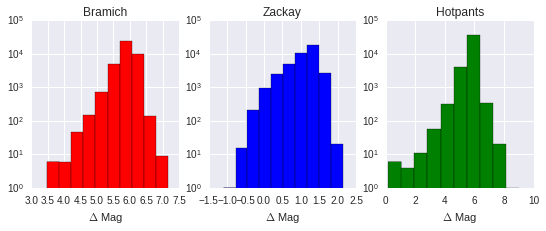

In [26]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.hist(detections['MAG_OFFSET_ois'], log=True, color='red')
plt.title('Bramich')
plt.xlabel(r'$\Delta$ Mag')

plt.subplot(132)
plt.hist(detections['MAG_OFFSET_zps'], log=True, color='blue')
plt.xlabel(r'$\Delta$ Mag')
plt.title('Zackay')

plt.subplot(133)
plt.hist(detections['MAG_OFFSET'], log=True, color='green')
plt.xlabel(r'$\Delta$ Mag')
plt.title('Hotpants')
#plt.show()

plt.savefig(os.path.join(plot_dir, 'mag_offset.png'), format='png', dpi=700)

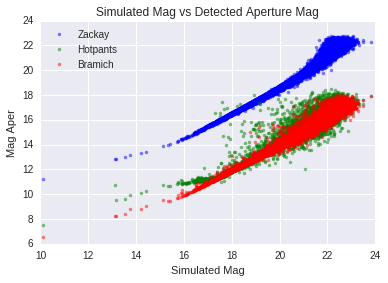

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(detections['sim_mag_zps'], detections['MAG_ISO_zps'], 'b.', label='Zackay', alpha=0.5)
plt.plot(detections['sim_mag'], detections['MAG_ISO'], 'g.', label='Hotpants', alpha=0.5)
plt.plot(detections['sim_mag_ois'], detections['MAG_ISO_ois'], 'r.', label='Bramich', alpha=0.5)

plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')
plt.savefig(os.path.join(plot_dir, 'aper_vs_simulated_mag.png'), format='png', dpi=700)

In [28]:
print 'Mean magniutde difference for Zackay is {}'.format(detections.MAG_OFFSET_zps.mean())
print 'Mean magniutde difference for Bramich is {}'.format(detections.MAG_OFFSET_ois.mean())
print 'Mean magniutde difference for Hotpans is {}'.format(detections.MAG_OFFSET.mean())

Mean magniutde difference for Zackay is 1.08637505036
Mean magniutde difference for Bramich is 5.90263420266
Mean magniutde difference for Hotpans is 5.84030110016


In [29]:
dt_ois['mag'] = dt_ois['MAG_ISO'] + detections.MAG_OFFSET_ois.mean()
dt_zps['mag'] = dt_zps['MAG_ISO'] + detections.MAG_OFFSET_zps.mean()
dt_hot['mag'] = dt_hot['MAG_ISO'] + detections.MAG_OFFSET.mean()

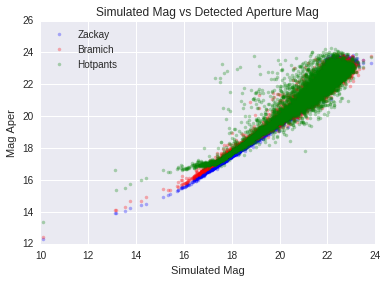

In [30]:
plt.plot(detections['sim_mag_zps'], 
         detections['MAG_ISO_zps'] + detections.MAG_OFFSET_zps.mean(),
         'b.', label='Zackay', alpha=0.3)
plt.plot(detections['sim_mag_ois'],
         detections['MAG_ISO_ois'] + detections.MAG_OFFSET_ois.mean(),
         'r.', label='Bramich', alpha=0.3)
plt.plot(detections['sim_mag'],
         detections['MAG_ISO'] + detections.MAG_OFFSET.mean(),
         'g.', label='Hotpants', alpha=0.3)

plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'corrected_aper_vs_simulated_mag.png'), format='png', dpi=900)

In [31]:
dt_ois['mu'] = dt_ois.mag/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['mu'] = dt_zps.mag/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)
dt_hot['mu'] = dt_hot.mag/(dt_hot.A_IMAGE*dt_hot.B_IMAGE)

In [32]:
bogus_b = dt_ois[dt_ois.IS_REAL==False]
reals_b = dt_ois[dt_ois.IS_REAL==True]

bogus_z = dt_zps[dt_zps.IS_REAL==False]
reals_z = dt_zps[dt_zps.IS_REAL==True]

bogus_h = dt_hot[dt_hot.IS_REAL==False]
reals_h = dt_hot[dt_hot.IS_REAL==True]

In [33]:
print len(bogus_b), len(bogus_z), len(bogus_h)

76722 15393 243953


## Luminosity function 

Bogus, Real, and FN luminosity functions.


In [34]:
reals_b.mag.values

array([ 21.7356342,  18.5669342,  21.1901342, ...,  22.6418342,
        20.8950342,  19.9020342])

In [35]:
def custom_histogram(vector, bins=None, cumulative=False):
    if bins is None:
        hh = np.histogram(vector)
    else: 
        hh = np.histogram(vector, bins=bins)
    dx = hh[1][1] - hh[1][0]
    x_bins = hh[1][:-1] + dx
    if cumulative is True:
        vals = [sum(hh[0][:i+1]) for i, _ in enumerate(hh[0])]
        return x_bins, vals
    elif cumulative == -1:
        vals = [sum(hh[0][i:]) for i, _ in enumerate(hh[0])]
        return x_bins, vals
    else:
        return x_bins, hh[0]

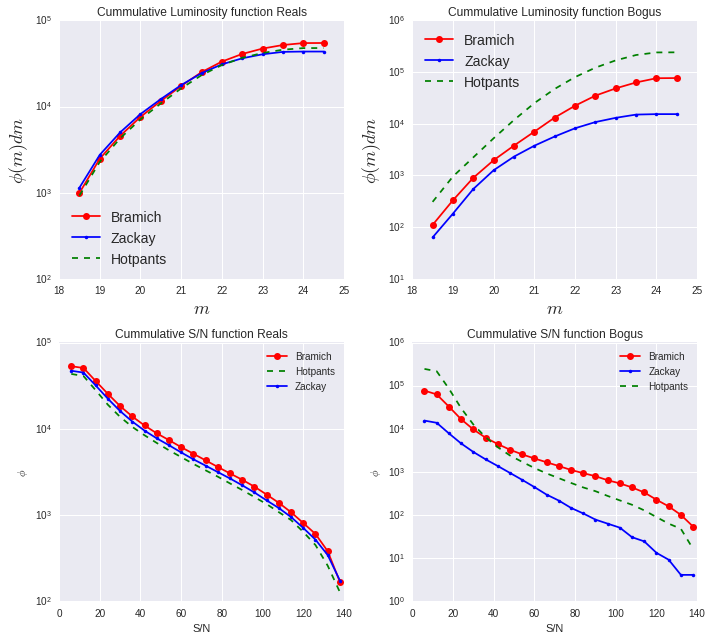

In [39]:
plt.figure(figsize=(10,9))

#magnitude bins
bins = np.arange(18, 25, 0.5)

plt.subplot(221)
cumulative=True
x_bins, vals = custom_histogram(reals_b.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(reals_h.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='Hotpants')
#plt.xlim(18, 24.5)
plt.title('Cummulative Luminosity function Reals')
plt.ylabel(r'$\phi(m)dm$', fontsize=18)
plt.legend(loc='best', fontsize=14)
plt.xlabel(r'$m$', fontsize=18)

plt.subplot(222)
x_bins, vals = custom_histogram(bogus_b.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='Hotpants')

#plt.xlim(20, 24.5)
plt.ylabel(r'$\phi(m)dm$', fontsize=18)
plt.legend(loc='best', fontsize=14)
plt.xlabel(r'$m$', fontsize=18)
plt.title('Cummulative Luminosity function Bogus')


#signal to noise bins
bins = np.arange(0, 140, 6)
cumulative=-1
plt.subplot(223)

x_bins, vals = custom_histogram((reals_b.FLUX_ISO/reals_b.FLUXERR_ISO).values, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram((reals_z.FLUX_ISO/reals_z.FLUXERR_ISO).values, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='Hotpants')
x_bins, vals = custom_histogram((reals_h.FLUX_ISO/reals_h.FLUXERR_ISO).values,
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')

#plt.xlim(110, 0)
plt.title('Cummulative S/N function Reals')
plt.legend(loc='best')
plt.ylabel(r'$\phi$')
plt.xlabel('S/N')

plt.subplot(224)
x_bins, vals = custom_histogram((bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO).values, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram((bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO).values,
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram((bogus_h.FLUX_ISO/bogus_h.FLUXERR_ISO).values, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='Hotpants')

#plt.xlim(70, 0)
plt.title('Cummulative S/N function Bogus')
plt.ylabel(r'$\phi$')
plt.legend(loc='best')
plt.xlabel('S/N')

plt.tight_layout()
#plt.show()

plt.savefig(os.path.join(plot_dir, 'luminosities_functions.png'), format='png', dpi=700)

## What about the FN?

We should check on the lost objects.

### Luminosity function for Undetected

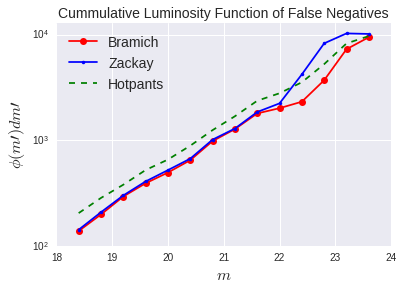

In [52]:
bins = np.arange(18, 24, 0.4)

plt.figure()
cumulative=False
x_bins, vals = custom_histogram(und_b.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(und_h.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='Hotpants')

plt.legend(loc='upper left', fontsize=14)
if cumulative:
    plt.ylabel(r'$\int_{-\infty}^{m}\phi(m\prime)dm\prime$', fontsize=16)
else:
    plt.ylabel(r'$\phi(m\prime)dm\prime$', fontsize=16)
plt.xlabel(r'$m$', fontsize=16)
plt.title('Cummulative Luminosity Function of False Negatives', fontsize=14)
#plt.xlim(21., 23.1)
#plt.show()
plt.ylim(100, 13e3)
plt.savefig(os.path.join(plot_dir, 'lum_function_FNegatives.png'), format='png', dpi=700)

### Are there coincident objects?

In [53]:
und_b.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [54]:
und_z.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [55]:
und_mix = pd.merge(left=und_b, right=und_z, on='simulated_id', 
                   suffixes=('_b', '_z'), how='outer', indicator='lisb_risz')

In [56]:
und_h.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [57]:
und_mix.columns

Index([         u'x_b',          u'y_b',    u'app_mag_b',   u'image_id_b',
       u'simulated_id',          u'x_z',          u'y_z',    u'app_mag_z',
         u'image_id_z',    u'lisb_risz'],
      dtype='object')

In [58]:
und_mix = pd.merge(left=und_mix, right=und_h, on='simulated_id', 
                   suffixes=('', '_h'), how='outer', indicator='lismix_rish')

In [59]:
und_mix.columns

Index([         u'x_b',          u'y_b',    u'app_mag_b',   u'image_id_b',
       u'simulated_id',          u'x_z',          u'y_z',    u'app_mag_z',
         u'image_id_z',    u'lisb_risz',            u'x',            u'y',
            u'app_mag',     u'image_id',  u'lismix_rish'],
      dtype='object')

In [60]:
case = [] 
for _, row in und_mix.iterrows():
    
    if row['lismix_rish']=='both':
        if row['lisb_risz']=='both':
            case.append('all')
        elif row['lisb_risz']=='left_only':
            case.append('b_and_h')
        else:
            case.append('z_and_h')
    
    elif row['lismix_rish']=='left_only':
        if row['lisb_risz']=='both':
            case.append('b_and_z')
        elif row['lisb_risz']=='left_only':
            case.append('only_b')
        else:
            case.append('only_z')
    
    elif row['lismix_rish']=='right_only':
        case.append('only_h')

und_mix['origin'] = case

In [61]:
magnitudes_und = pd.DataFrame({#'mag_all'    : und_mix[und_mix.origin=='all'].app_mag,
                               'mag_onlyb'  : und_mix[und_mix.origin=='only_b'].app_mag_b,
                               'mag_onlyz'  : und_mix[und_mix.origin=='only_z'].app_mag_z,
                               'mag_onlyh'  : und_mix[und_mix.origin=='only_h'].app_mag,
                               'mag_b_and_h': und_mix[und_mix.origin=='b_and_h'].app_mag,
                               'mag_z_and_h': und_mix[und_mix.origin=='z_and_h'].app_mag,
                               'mag_b_and_z': und_mix[und_mix.origin=='b_and_z'].app_mag_b})

(1.0, 10000)

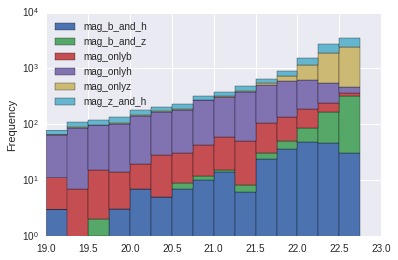

In [62]:
bins = np.arange(19, 23., 0.25)
plt.figure(figsize=(10, 10))
magnitudes_und.plot.hist(stacked=True, bins=bins, log=True)
plt.legend(loc='upper left')
plt.ylim(0, 10000)

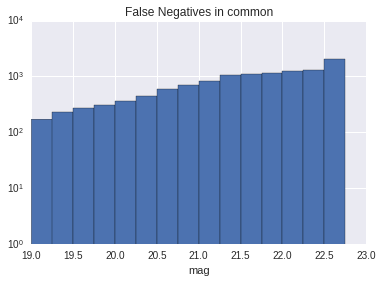

In [63]:
bins = np.arange(19, 23., 0.25)
plt.hist(und_mix.app_mag[und_mix.origin=='all'], bins=bins, log=True)
plt.title('False Negatives in common')
plt.xlabel('mag')
plt.xlim(19, 23.)
plt.ylim(1, 10000)
plt.show()

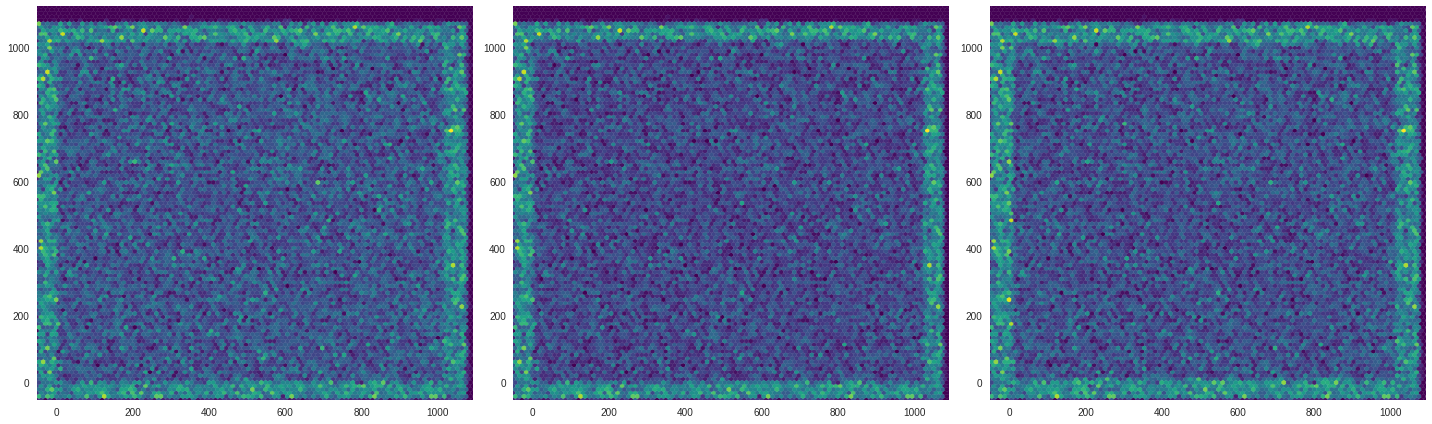

In [64]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.hexbin(und_z.x, und_z.y, cmap='viridis')
#plt.colorbar()
plt.subplot(132)
plt.hexbin(und_b.x, und_b.y, cmap='viridis')
#plt.colorbar()
plt.subplot(133)
plt.hexbin(und_h.x, und_h.y, cmap='viridis')
#plt.colorbar()
plt.tight_layout()
plt.show()

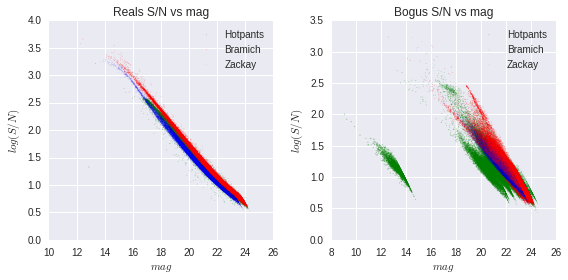

In [67]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_h.mag, 
         np.log10(reals_h.FLUX_ISO/reals_h.FLUXERR_ISO), 
         s=np.log10(reals_h.FLUXERR_ISO), linewidths=0.001,
         c='g', marker='.', alpha=0.3, label='Hotpants')
plt.scatter(reals_b.mag, 
         np.log10(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO),
         s=np.log10(reals_b.FLUXERR_ISO), linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag, 
         np.log10(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO), 
         s=np.log10(reals_z.FLUXERR_ISO), linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')

# plt.xlim(18,25)
# plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')


plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_h.mag,
            np.log10(bogus_h.FLUX_ISO/bogus_h.FLUXERR_ISO),
            s=np.log10(bogus_h.FLUXERR_ISO), linewidths=0.001,
            c='g', marker='.', alpha=0.3, label='Hotpants')
plt.scatter(bogus_b.mag,
            np.log10(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO),
            s=np.log10(bogus_b.FLUXERR_ISO), linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag,
            np.log10(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO),
            s=np.log10(bogus_z.FLUXERR_ISO), linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')

# plt.xlim(18,25)
# plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

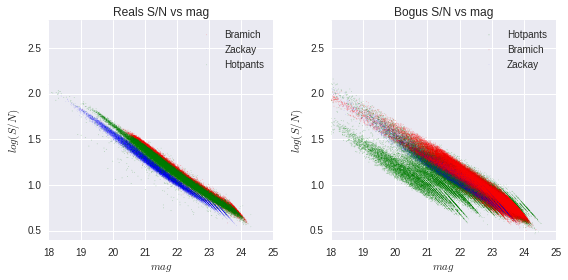

In [182]:
low_cstar_b = reals_b.CLASS_STAR < 0.005
low_cstar_z = reals_z.CLASS_STAR < 0.005
low_cstar_h = reals_h.CLASS_STAR < 0.005

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_b.mag[low_cstar_b], 
         np.log10(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO)[low_cstar_b],
         s=np.log10(reals_b.FLUXERR_ISO)[low_cstar_b], linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag[low_cstar_z], 
         np.log10(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO)[low_cstar_z], 
         s=np.log10(reals_z.FLUXERR_ISO)[low_cstar_z], linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.scatter(reals_h.mag[low_cstar_h], 
         np.log10(reals_h.FLUX_ISO/reals_h.FLUXERR_ISO)[low_cstar_h],
         s=np.log10(reals_h.FLUXERR_ISO)[low_cstar_h], linewidths=0.001, 
        c='g', marker='.', alpha=0.3, label='Hotpants')
plt.xlim(18,25)
plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')

low_cstar_b = bogus_b.CLASS_STAR < 0.005
low_cstar_z = bogus_z.CLASS_STAR < 0.005
low_cstar_h = bogus_h.CLASS_STAR < 0.005

plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_h.mag[low_cstar_h],
            np.log10(bogus_h.FLUX_ISO/bogus_h.FLUXERR_ISO)[low_cstar_h],
            s=np.log10(bogus_h.FLUXERR_ISO)[low_cstar_h], linewidths=0.001,
            c='g', marker='.', alpha=0.3, label='Hotpants')
plt.scatter(bogus_b.mag[low_cstar_b],
            np.log10(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO)[low_cstar_b],
            s=np.log10(bogus_b.FLUXERR_ISO)[low_cstar_b], linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag[low_cstar_z],
            np.log10(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO)[low_cstar_z],
            s=np.log10(bogus_z.FLUXERR_ISO)[low_cstar_z], linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

Need to calculate mean and dispersion of log10(S/N) on magnitude bins.

In [183]:
def binning(data, bins, step):
    meanlogsn = []
    stdvlogsn = []
    
    for abin in bins:
        fdata = data[(data.mag < abin + step) * (data.mag >= abin)]
        meanlogsn.append(np.mean(np.log10(fdata.FLUX_ISO/fdata.FLUXERR_ISO)))
        stdvlogsn.append(np.std( np.log10(fdata.FLUX_ISO/fdata.FLUXERR_ISO)))
    return meanlogsn, stdvlogsn

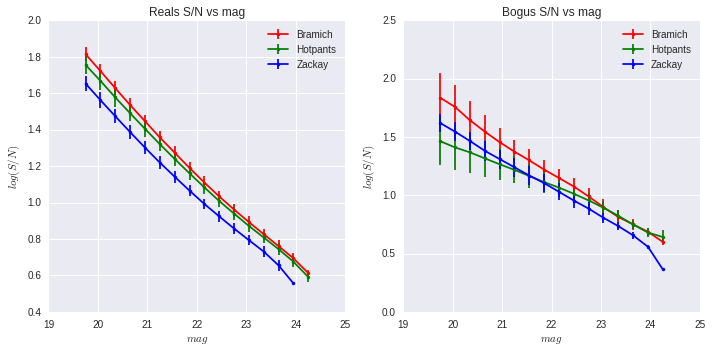

In [184]:
step = 0.3
bins = np.arange(19.6, 24.4, step)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Reals S/N vs mag')
means, stds = binning(reals_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001, 
             c='r', marker='.', alpha=1, label='Bramich')
means, stds = binning(reals_h, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001, 
             c='g', marker='.', alpha=1, label='Hotpants')
means, stds = binning(reals_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             c='b', marker='.', alpha=1, label='Zackay')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus S/N vs mag')
means, stds = binning(bogus_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
            #linewidths=0.001,
            c='r', marker='.', alpha=1, label='Bramich') 
means, stds = binning(bogus_h, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
            #linewidths=0.001,
            c='g', marker='.', alpha=1, label='Hotpants') 
means, stds = binning(bogus_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001,
             c='b', marker='.', alpha=1, label='Zackay')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag_binned.png'), format='png', dpi=700)

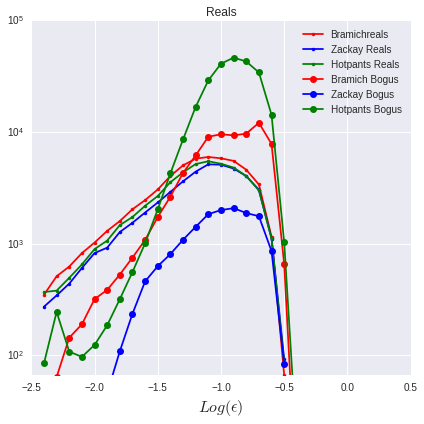

In [185]:
bins=np.arange(-2.5, 0.1, 0.1)
plt.figure(figsize=(6, 6))
#plt.subplot(121)
plt.title('Reals')
# plt.hist([np.log10(reals_b.MAGERR_ISO[reals_b.MAG_ISO < 30]),
#           np.log10(reals_h.MAGERR_ISO[reals_h.MAG_ISO < 30]),
#           np.log10(reals_z.MAGERR_ISO[reals_z.MAG_ISO < 30])],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'], 
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(np.log10(reals_b.MAGERR_ISO[reals_b.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'r.-', label='Bramichreals')
x_bins, vals = custom_histogram(np.log10(reals_z.MAGERR_ISO[reals_z.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay Reals')
x_bins, vals = custom_histogram( np.log10(reals_h.MAGERR_ISO[reals_h.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g.-', label='Hotpants Reals')


plt.xlabel(r'$Log(\epsilon)$', fontsize=16)
#plt.xlim(-3.5, 0.)
plt.ylim(0, 10e4)
# plt.legend(loc='best')

# plt.subplot(122)
# plt.title('Bogus')
# plt.hist([np.log10(bogus_b.MAGERR_ISO[bogus_b.MAG_ISO < 30]),
#           np.log10(bogus_h.MAGERR_ISO[bogus_h.MAG_ISO < 30]),
#           np.log10(bogus_z.MAGERR_ISO[bogus_z.MAG_ISO < 30])],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'], 
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(np.log10(bogus_b.MAGERR_ISO[bogus_b.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich Bogus')
x_bins, vals = custom_histogram(np.log10(bogus_z.MAGERR_ISO[bogus_z.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay Bogus')
x_bins, vals = custom_histogram(np.log10(bogus_h.MAGERR_ISO[bogus_h.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants Bogus')

#plt.xlabel(r'$Log(\epsilon)$')
#plt.xlim(-3.5, 0.)
#plt.ylim(0, 100000)
plt.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'mag_errors.png'), format='png', dpi=700)

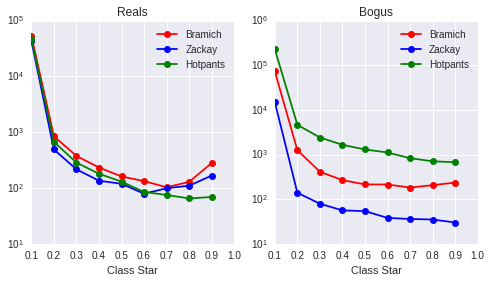

In [186]:
bins = np.arange(0, 1., 0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
# plt.hist([reals_b.CLASS_STAR, reals_h.CLASS_STAR, reals_z.CLASS_STAR],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(reals_b.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'Class Star')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
# plt.hist([bogus_b.CLASS_STAR, bogus_h.CLASS_STAR, bogus_z.CLASS_STAR],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(bogus_b.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'Class Star')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'class_star_hist.png'), format='png', dpi=700)

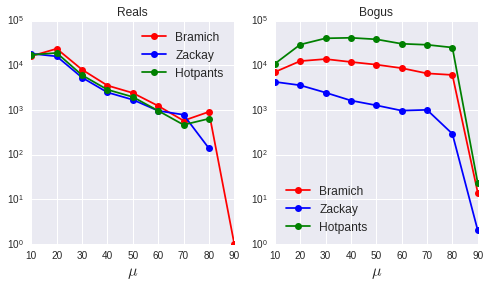

In [187]:
bins = np.arange(0, 100, 10)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
# plt.hist([reals_b.mu, reals_h.mu, reals_z.mu],
#          color=['red', 'green', 'blue'], bins=bins,
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(reals_b.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$\mu$', fontsize=16)
plt.legend(loc='best', fontsize=12)

plt.subplot(122)
plt.title('Bogus')
# plt.hist([bogus_b.mu, bogus_h.mu, bogus_z.mu],
#          color=['red', 'green', 'blue'], bins=bins,
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(bogus_b.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$\mu$', fontsize=16)
plt.legend(loc='best', fontsize=12)

plt.savefig(os.path.join(plot_dir, 'mu_hist.png'), format='png', dpi=700)

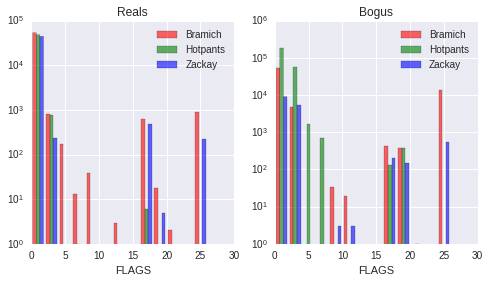

In [188]:
bins = np.arange(0, 28, 2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist([reals_b.FLAGS, reals_h.FLAGS, reals_z.FLAGS],
         color=['red', 'green', 'blue'], bins=bins,
         label=['Bramich', 'Hotpants', 'Zackay'],
         log=True, alpha=0.6)
plt.xlabel(r'FLAGS')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.hist([bogus_b.FLAGS, bogus_h.FLAGS, bogus_z.FLAGS],
         color=['red', 'green', 'blue'], bins=bins,
         label=['Bramich', 'Hotpants', 'Zackay'],
         log=True, alpha=0.6)
plt.xlabel(r'FLAGS')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'flags_hist.png'), format='png', dpi=700)

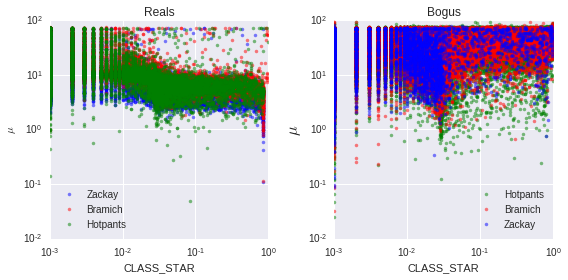

In [189]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.plot(reals_z.CLASS_STAR, reals_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')
plt.plot(reals_b.CLASS_STAR, reals_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(reals_h.CLASS_STAR, reals_h.mu, '.',
            alpha=0.5, color='green', label='Hotpants')

plt.xlim(0.001, 1.)
plt.ylim(0.01, 100)
plt.loglog()
plt.xlabel(r'CLASS_STAR')
plt.ylabel(r'$\mu$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.plot(bogus_h.CLASS_STAR, bogus_h.mu, '.', 
            alpha=0.5, color='green', label='Hotpants')
plt.plot(bogus_b.CLASS_STAR, bogus_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(bogus_z.CLASS_STAR, bogus_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')


plt.xlim(0.001, 1.)
plt.ylim(0.01, 100)
plt.loglog()
plt.xlabel(r'CLASS_STAR')
plt.ylabel(r'$\mu$', fontsize=16)
plt.legend(loc='best')
plt.tight_layout()

## Simulation parameters

We need data on simulation for every object, specially undetected (there are a lot of these)

In [190]:
sim_pars = pd.read_sql_query("""SELECT * FROM Images""", engine)

In [191]:
sim_pars = sim_pars.merge(simulated, left_on='id', right_on='image_id', 
                          how='right', suffixes=('_img', '_src'))

In [192]:
print und_b.columns, len(und_b), len(sim_pars)

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object') 65526 121613


In [193]:
sim_pars.columns

Index([u'id_img', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'id_src', u'code', u'x',
       u'y', u'app_mag', u'r_scales', u'gx_mag', u'image_id', u'image_id_ois',
       u'image_id_hot'],
      dtype='object')

In [194]:
und_b = pd.merge(left=und_b, right=sim_pars, left_on='simulated_id', right_on='id_src', how='left')
und_z = pd.merge(left=und_z, right=sim_pars, left_on='simulated_id', right_on='id_src', how='left')
und_h = pd.merge(left=und_h, right=sim_pars, left_on='simulated_id', right_on='id_src', how='left')

In [195]:
print und_b.columns, len(und_b)

Index([u'x_x', u'y_x', u'app_mag_x', u'image_id_x', u'simulated_id', u'id_img',
       u'path', u'crossmatched', u'refstarcount_zp', u'refstarcount_slope',
       u'refseeing_fwhm', u'id_src', u'code', u'x_y', u'y_y', u'app_mag_y',
       u'r_scales', u'gx_mag', u'image_id_y', u'image_id_ois',
       u'image_id_hot'],
      dtype='object') 65526


In [196]:
print ' Columns of sim_pars:\n', sim_pars.columns
print '\n Columns of und_b:\n', und_b.columns
print '\n Columns of und_z:\n', und_z.columns
print '\n Columns of und_h:\n', und_h.columns
print '\n Columns of simulated:\n', simulated.columns

 Columns of sim_pars:
Index([u'id_img', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'id_src', u'code', u'x',
       u'y', u'app_mag', u'r_scales', u'gx_mag', u'image_id', u'image_id_ois',
       u'image_id_hot'],
      dtype='object')

 Columns of und_b:
Index([u'x_x', u'y_x', u'app_mag_x', u'image_id_x', u'simulated_id', u'id_img',
       u'path', u'crossmatched', u'refstarcount_zp', u'refstarcount_slope',
       u'refseeing_fwhm', u'id_src', u'code', u'x_y', u'y_y', u'app_mag_y',
       u'r_scales', u'gx_mag', u'image_id_y', u'image_id_ois',
       u'image_id_hot'],
      dtype='object')

 Columns of und_z:
Index([u'x_x', u'y_x', u'app_mag_x', u'image_id_x', u'simulated_id', u'id_img',
       u'path', u'crossmatched', u'refstarcount_zp', u'refstarcount_slope',
       u'refseeing_fwhm', u'id_src', u'code', u'x_y', u'y_y', u'app_mag_y',
       u'r_scales', u'gx_mag', u'image_id_y', u'image_id_ois',
       u'image_id_hot'],
      dtype

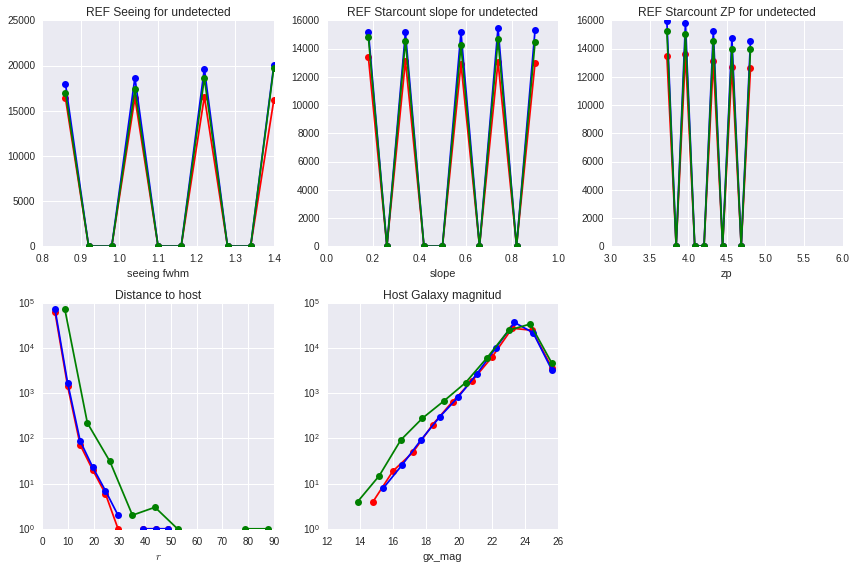

In [200]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
# plt.hist([und_z['refseeing_fwhm'], und_h['refseeing_fwhm'], und_b['refseeing_fwhm']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=True)
cumulative=False
x_bins, vals = custom_histogram(und_b['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('seeing fwhm')
# plt.ylim(4000, 7000)
plt.title('REF Seeing for undetected')

plt.subplot(2, 3, 2)
# plt.hist([und_z['refstarcount_slope'], und_h['refstarcount_slope'], und_b['refstarcount_slope']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(und_b['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('slope')
plt.xlim(0, 1.)
# plt.ylim(4000, 7000)
plt.title('REF Starcount slope for undetected')

plt.subplot(2, 3, 3)
# plt.hist([np.log10(und_z['refstarcount_zp']), 
#           np.log10(und_h['refstarcount_zp']), 
#           np.log10(und_b['refstarcount_zp'])],
#           color=['blue', 'green', 'red'], 
#           label=['Zackay', 'Hotpants', 'Bramich'],
#           cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(np.log10(und_b['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(np.log10(und_z['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(np.log10(und_h['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
# plt.ylim(4000, 7000)
plt.xlim(3, 6)
plt.xlabel('zp')
plt.title('REF Starcount ZP for undetected')

plt.subplot(2, 3, 4)
# plt.hist([und_z['r_scales'], und_h['r_scales'], und_b['r_scales']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(und_b['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$r$')
plt.title('Distance to host')

plt.subplot(2, 3, 5)
# plt.hist([und_z['gx_mag'], und_h['gx_mag'], und_b['gx_mag']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#         cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(und_b['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'gx_mag')
plt.title('Host Galaxy magnitud')

plt.tight_layout()
plt.show()

### Simulation parameters for reals

In [201]:
sim_pars.columns

Index([u'id_img', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'id_src', u'code', u'x',
       u'y', u'app_mag', u'r_scales', u'gx_mag', u'image_id', u'image_id_ois',
       u'image_id_hot'],
      dtype='object')

In [202]:
reals_b.columns

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',           u'mag',          

In [203]:
reals_b = pd.merge(left=reals_b, right=sim_pars, 
                   left_on='sim_id', right_on='id_src', how='left')
reals_z = pd.merge(left=reals_z, right=sim_pars, 
                   left_on='sim_id', right_on='id_src', how='left')
reals_h = pd.merge(left=reals_h, right=sim_pars, 
                   left_on='sim_id', right_on='id_src', how='left')

In [204]:
reals_b.columns

Index([                u'id',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

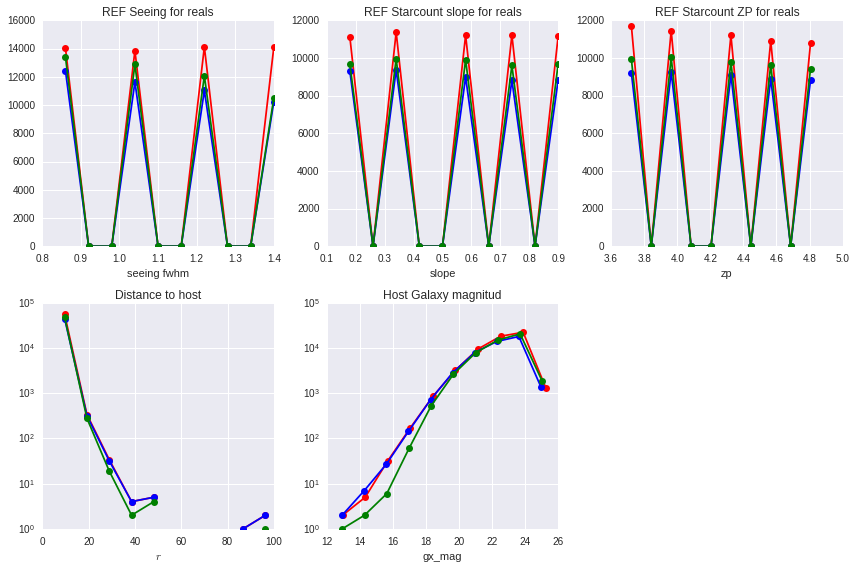

In [206]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
# plt.hist([und_z['refseeing_fwhm'], und_h['refseeing_fwhm'], und_b['refseeing_fwhm']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=True)
cumulative=False
x_bins, vals = custom_histogram(reals_b['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('seeing fwhm')
# plt.ylim(2500, 5000)
plt.title('REF Seeing for reals')

plt.subplot(2, 3, 2)
# plt.hist([und_z['refstarcount_slope'], und_h['refstarcount_slope'], und_b['refstarcount_slope']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(reals_b['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('slope')
# plt.xlim(0, 1.)
# plt.ylim(2500, 5000)
plt.title('REF Starcount slope for reals')

plt.subplot(2, 3, 3)
# plt.hist([np.log10(und_z['refstarcount_zp']), 
#           np.log10(und_h['refstarcount_zp']), 
#           np.log10(und_b['refstarcount_zp'])],
#           color=['blue', 'green', 'red'], 
#           label=['Zackay', 'Hotpants', 'Bramich'],
#           cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(np.log10(reals_b['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(np.log10(reals_z['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(np.log10(reals_h['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
# plt.ylim(2500, 5000)
# plt.xlim(3, 6)
plt.xlabel('zp')
plt.title('REF Starcount ZP for reals')

plt.subplot(2, 3, 4)
# plt.hist([und_z['r_scales'], und_h['r_scales'], und_b['r_scales']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(reals_b['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$r$')
plt.title('Distance to host')

plt.subplot(2, 3, 5)
# plt.hist([und_z['gx_mag'], und_h['gx_mag'], und_b['gx_mag']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#         cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(reals_b['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'gx_mag')
plt.title('Host Galaxy magnitud')

plt.tight_layout()
plt.show()

### Simulation parameters for bogus

In [207]:
sim_pars = pd.read_sql_query("""SELECT * FROM Images""", engine)

In [208]:
sim_pars.columns

Index([u'id', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm'],
      dtype='object')

In [209]:
print bogus_b.columns, len(bogus_b), len(sim_pars)

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',           u'mag',          

In [210]:
tl = bogus_b.sample(200)
tr = sim_pars.sample(200)

In [211]:
pd.merge(left=tl, right=tr, left_on='image_id', right_on='id', how='left')

,id_x,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,sim_mag,sim_id,mag,mu,id_y,path,crossmatched,refstarcount_zp,refstarcount_slope,refseeing_fwhm
0,36996,6,694.6253,132.6125,17.8956,0.2073,1217.9240,263.3620,17.2859,0.2348,...,NaN,NaN,23.798191,64.744651,NaN,NaN,NaN,NaN,NaN,NaN
1,87595,67,1733.2090,193.0925,16.9029,0.1210,1216.2490,210.6391,17.2874,0.1881,...,NaN,NaN,22.805491,29.489148,NaN,NaN,NaN,NaN,NaN,NaN
2,65257,4,2587.5610,167.1977,16.4678,0.0702,2117.1670,199.7062,16.6856,0.1024,...,NaN,NaN,22.370391,26.134490,NaN,NaN,NaN,NaN,NaN,NaN
3,16114,82,23394.0400,333.0743,14.0772,0.0155,20471.8100,248.7408,14.2221,0.0132,...,NaN,NaN,19.979791,12.008890,NaN,NaN,NaN,NaN,NaN,NaN
4,74668,40,1906.9520,195.3669,16.7992,0.1113,2128.0860,239.6425,16.6800,0.1223,...,NaN,NaN,22.701791,23.639130,692.0,/home/bruno/Data/RBpipeline/images/img00692/di...,1.0,64000.0,0.7,0.8
5,51432,79,9769.2540,349.8764,15.0253,0.0389,6536.1460,238.5228,15.4617,0.0396,...,NaN,NaN,20.927891,8.430236,NaN,NaN,NaN,NaN,NaN,NaN
6,125506,259,5093.9840,313.5779,15.7324,0.0669,2529.0180,249.5947,16.4926,0.1072,...,NaN,NaN,21.634991,13.399947,NaN,NaN,NaN,NaN,NaN,NaN
7,89087,53,9165.5610,420.1812,15.0946,0.0498,2391.5280,247.7617,16.5533,0.1125,...,NaN,NaN,20.997191,6.472384,NaN,NaN,NaN,NaN,NaN,NaN
8,1373,25,908.8563,138.0728,17.6038,0.1650,1272.0780,249.2969,17.2387,0.2128,...,NaN,NaN,23.506391,48.306131,NaN,NaN,NaN,NaN,NaN,NaN
9,89542,183,869.0295,137.7311,17.6524,0.1721,1240.9810,214.5542,17.2656,0.1878,...,NaN,NaN,23.554991,59.601504,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
try:
    bogus_b = pd.from_csv('bogus_b_csv.csv')
except:
    bogus_b = pd.merge(left=bogus_b, right=sim_pars, 
                   left_on='image_id', right_on='id', how='left')
    bogus_b.to_csv('bogus_b_csv.csv')

In [213]:
print bogus_b.columns, len(bogus_b)

Index([              u'id_x',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

In [214]:
print bogus_h.columns, len(bogus_h)

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',           u'mag',          

In [215]:
try:
    bogus_h = pd.from_csv('bogus_h_csv.csv')
except:
    bogus_h = pd.merge(left=bogus_h, right=sim_pars, 
                       left_on='image_id', right_on='id', how='left')
    bogus_h.to_csv('bogus_h_csv.csv')

In [216]:
print bogus_h.columns, len(bogus_h), len(sim_pars)

Index([              u'id_x',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

In [217]:
try:
    bogus_z = pd.from_csv('bogus_z_csv.csv')
except:
    bogus_z = pd.merge(left=bogus_z, right=sim_pars, 
                   left_on='image_id', right_on='id', how='left')
    bogus_z.to_csv('bogus_z_csv.csv')

In [218]:
bogus_b.columns

Index([              u'id_x',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

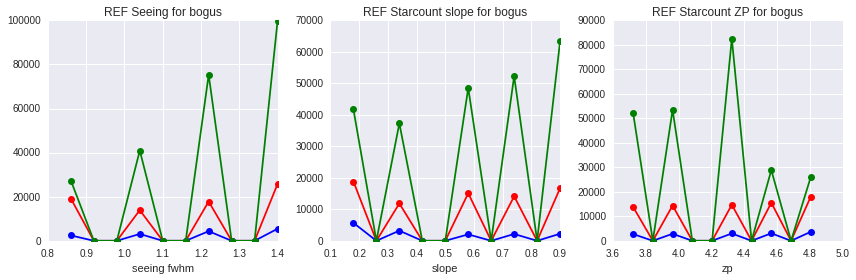

In [219]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
# plt.hist([und_z['refseeing_fwhm'], und_h['refseeing_fwhm'], und_b['refseeing_fwhm']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=True)
cumulative=False
x_bins, vals = custom_histogram(bogus_b['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h['refseeing_fwhm'], cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('seeing fwhm')
#plt.ylim(2500, 5000)
plt.title('REF Seeing for bogus')

plt.subplot(1, 3, 2)
# plt.hist([und_z['refstarcount_slope'], und_h['refstarcount_slope'], und_b['refstarcount_slope']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(bogus_b['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h['refstarcount_slope'], cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('slope')
# plt.xlim(0, 1.)
#plt.ylim(2500, 5000)
plt.title('REF Starcount slope for bogus')

plt.subplot(1, 3, 3)
# plt.hist([np.log10(und_z['refstarcount_zp']), 
#           np.log10(und_h['refstarcount_zp']), 
#           np.log10(und_b['refstarcount_zp'])],
#           color=['blue', 'green', 'red'], 
#           label=['Zackay', 'Hotpants', 'Bramich'],
#           cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(np.log10(bogus_b['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(np.log10(bogus_z['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(np.log10(bogus_h['refstarcount_zp']), cumulative=cumulative)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
#plt.ylim(2500, 5000)
# plt.xlim(3, 6)
plt.xlabel('zp')
plt.title('REF Starcount ZP for bogus')

plt.tight_layout()
plt.show()

## Checking on the outliers

In [ ]:
from astropy.nddata.utils import extract_array
from astropy.io import fits


def get_patch_bramich(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff_ois.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    
    
def get_patch_zackay(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    

In [ ]:
outliers_b = bogus_b[bogus_b.CLASS_STAR > .97]

In [ ]:
outliers_b

In [ ]:
plt.figure(figsize=( 6, 2*len(outliers_b)))
for i in range(len(outliers_b)):
    patch = get_patch_bramich(outliers_b[i:i+1]['Y_IMAGE'], 
                              outliers_b[i:i+1]['X_IMAGE'], 
                              int(outliers_b[i:i+1]['image_id']))
    plt.subplot(len(outliers_b), 1 , i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')

In [ ]:
outliers_z = bogus_z[bogus_z.ELONGATION > 8]

In [ ]:
outliers_z

In [ ]:
plt.figure(figsize=(6*len(outliers_z), 12))
for i in range(len(outliers_z)):
    patch = get_patch_zackay(outliers_z[i:i+1]['Y_IMAGE'], 
                              outliers_z[i:i+1]['X_IMAGE'], 
                              int(outliers_z[i:i+1]['image_id']))
    plt.subplot(1, len(outliers_z), i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')